In [114]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d

In [115]:
TIME_STEP = 1/1000

In [157]:
class Model:
    
    def __init__(self, noise_scale=0, noise_decay=0, noise_momentum=0.5):
        self.__x = 0
        self.__y = 0
        self.__z = 0
        self.__vx = 0
        self.__vy = 0
        self.__vz = 0
        self.__noise_scale = noise_scale
        self.__noise_decay = noise_decay
        self.__noise_momentum = noise_momentum
        self.noise = np.zeros(3)
    
    def step(self, ax, ay, az):
        noise = np.random.randn(3) * self.__noise_scale
        self.noise = \
            self.__noise_momentum*self.noise + \
            (1-self.__noise_momentum)*noise
        self.noise *= 1-self.__noise_decay
        ax += self.noise[0]
        ay += self.noise[1]
        az += self.noise[2]
        self.__x += self.__vx*TIME_STEP + 0.5*ax*TIME_STEP**2
        self.__y += self.__vy*TIME_STEP + 0.5*ay*TIME_STEP**2
        self.__z += self.__vz*TIME_STEP + 0.5*az*TIME_STEP**2
        self.__vx += ax*TIME_STEP
        self.__vy += ay*TIME_STEP
        self.__vz += az*TIME_STEP
        return self.__x, self.__y, self.__z

In [158]:
class PIDController:
    
    def __init__(self, Kp, Ki, Kd):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.disable_integral = False
        self.ierr = 0
        self.__prev_err = 0
    
    def step(self, measured, desired):
        err = desired - measured
        self.ierr = 0 if self.disable_integral else self.ierr + err*TIME_STEP
        derr = (err-self.__prev_err)/TIME_STEP
        self.__prev_err = err
        return self.Kp*err + self.Ki*self.ierr + self.Kd*derr

final noise -0.20100585097060877 -0.3696134525005452 -0.1858136224837944
final ierr -0.07319548262036328 0.012225219566371112 8.63437735631915
final err 0.07943941626380058 0.00852658307101739 -2.513561554481754


<IPython.core.display.Javascript object>


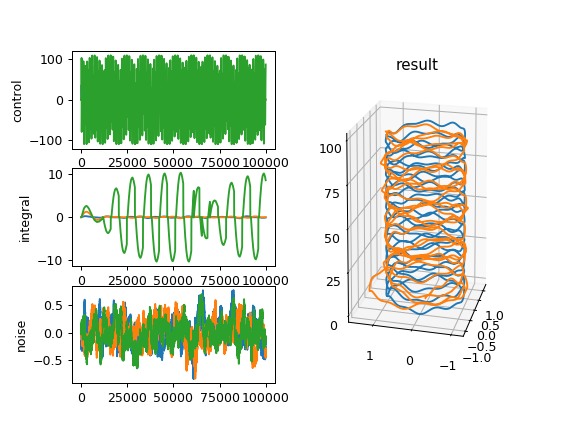

In [172]:
Kp,Ki,Kd = 10,10,35
control_max = 110
model = Model(noise_scale=10, noise_decay=0, noise_momentum=0.999)
pid_x, pid_y, pid_z = [PIDController(Kp,Ki,Kd) for _ in range(3)]
x,y,z = model.step(0,0,0)
target = lambda t: (
    np.sin(t/1000),
    np.cos(t/1000),
    np.sin(t/107)+np.sin(t/199)+t/1000)
T, Y, C, I, N = [[] for _ in range(5)]
for t in range(100000):
    tx,ty,tz = target(t)
    cx = pid_x.step(x,tx)
    cy = pid_y.step(y,ty)
    cz = pid_z.step(z,tz)
    clen = np.linalg.norm((cx,cy,cz))
    pid_x.disable_integral = \
    pid_y.disable_integral = \
    pid_z.disable_integral = clen > control_max
    if clen > control_max:
        cx,cy,cz = cx/clen, cy/clen, cz/clen
    x,y,z = model.step(cx,cy,cz)
    T.append((tx,ty,tz))
    Y.append((x,y,z))
    C.append((cx,cy,cz))
    I.append((pid_x.ierr, pid_y.ierr, pid_z.ierr))
    N.append(model.noise)
print('final noise', *model.noise)
print('final ierr', pid_x.ierr, pid_y.ierr, pid_z.ierr)
print('final err', tx-x, ty-y, tz-z)
plt.subplot(122, projection='3d'); plt.title('result');
plt.plot(*np.moveaxis(T,0,-1)); plt.plot(*np.moveaxis(Y,0,-1))
plt.subplot(321); plt.ylabel('control'); plt.plot(C)
plt.subplot(323); plt.ylabel('integral'); plt.plot(I)
plt.subplot(325); plt.ylabel('noise'); plt.plot(N)
plt.show()